<a href="https://colab.research.google.com/github/VMBoehm/pca-classifier/blob/master/notebooks/ood_data_space_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import os
import pickle
from   sklearn import decomposition, covariance
import numpy as np
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

Populating the interactive namespace from numpy and matplotlib


Let's do some outlier detection with linear data compression and a Gaussian likelihood!

In [2]:
! pip install git+https://github.com/VMBoehm/pca-classifier

  Cloning https://github.com/VMBoehm/pca-classifier to /tmp/pip-req-build-ycrghsp1
  Running command git clone -q https://github.com/VMBoehm/pca-classifier /tmp/pip-req-build-ycrghsp1
  Created wheel for pca-classifier: filename=pca_classifier-0.1.dev56+g7dbc571-cp36-none-any.whl size=21599 sha256=8be5639620dca0eaced74d51d86587c788c3ea5c107c2a50e4effadd44684d09
  Stored in directory: /tmp/pip-ephem-wheel-cache-su47zd55/wheels/b6/92/de/5e335df3a93aac71a83f93369b54139de22ab1656163dab574
Successfully built pca-classifier
  Found existing installation: pca-classifier 0.1.dev55+g1dfe21c
    Uninstalling pca-classifier-0.1.dev55+g1dfe21c:
      Successfully uninstalled pca-classifier-0.1.dev55+g1dfe21c


In [3]:
from pca_classifier import load_data, prepare_data

In [4]:
mnist_data  = load_data.load_mnist('./')
fmnist_data = load_data.load_fmnist('./')

datasets={}
datasets['fmnist']={}
datasets['mnist']={}
datasets['mnist']['train']  = mnist_data[0]
datasets['fmnist']['train'] = fmnist_data[0]
datasets['mnist']['test']   = mnist_data[2]
datasets['fmnist']['test']  = fmnist_data[2]

masked_datasets_train={}
masked_datasets_test ={}
masked_ood_datasets  ={}

In [5]:
#masked all pixels with a variance of<1e-8 in the train set
ts = -0.1

masked_datasets_train['mnist'], masked_in, masked_out  = prepare_data.mask_low_var_pixels(datasets['mnist']['train'],threshhold=ts)
masked_datasets_train['fmnist'], _, _ = prepare_data.mask_low_var_pixels(datasets['fmnist']['train'],threshhold=ts)

masked_datasets_test['mnist'], _, _  = prepare_data.mask_low_var_pixels(datasets['mnist']['test'],datasets['mnist']['train'],threshhold=ts)
masked_datasets_test['fmnist'], _, _ = prepare_data.mask_low_var_pixels(datasets['fmnist']['test'],datasets['fmnist']['train'],threshhold=ts)

#assume it's mnist, but it isn't
masked_ood_datasets['mnist'],_ ,_  = prepare_data.mask_low_var_pixels(datasets['fmnist']['test'],datasets['mnist']['train'],threshhold=ts)
#assume it's fmnist, but it isn't
masked_ood_datasets['fmnist'],_ ,_ = prepare_data.mask_low_var_pixels(datasets['mnist']['test'],datasets['fmnist']['train'],threshhold=ts)
print(masked_out)

[]


(-0.5, 27.5, 27.5, -0.5)

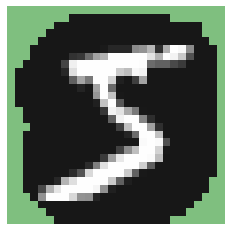

In [6]:
image = datasets['mnist']['train'][0]
mask  = np.ones_like(image)
mask[masked_in] = 0.
from copy import copy
palette = copy(plt.cm.gray)
palette.set_over('r', 0.0)
palette.set_under('green', 0.5)
palette.set_bad('darkgreen', 1.0)
ts = 1e-4
_, _ , masked_out_2  = prepare_data.mask_low_var_pixels(datasets['mnist']['train'],threshhold=ts)
# Alternatively, we could use
# palette.set_bad(alpha = 0.0)
# to make the bad region transparent.  This is the default.
# If you comment out all the palette.set* lines, you will see
# all the defaults; under and over will be colored with the
# first and last colors in the palette, respectively.
image[masked_out_2] = -0.5
Zm = np.ma.masked_array(image,mask=mask)
plt.imshow(Zm.reshape(28,28), cmap=palette, vmin=-0.1)
plt.axis('off')
#plt.savefig('../plots/variance_masked_mnist.png',bbox_inches='tight')

In [95]:
#fit pcas to both datasets

mnist_pcas=[]
fmnist_pcas=[]
recon_noise=[]
n_components = np.arange(4,28*28+28,78//2)
n_components = np.sort(list(n_components)+[8,16,32])

for ii, nn in enumerate(n_components):
    if nn ==-1:
        nn=masked_datasets_train['mnist'].shape[-1]
    mnist_pcas+=[decomposition.PCA(n_components=nn)]
    mnist_pcas[ii].fit(masked_datasets_train['mnist'])

for ii, nn in enumerate(n_components):
    if nn ==-1:
        nn=masked_datasets_train['fmnist'].shape[-1]
    fmnist_pcas+=[decomposition.PCA(n_components=nn)]
    fmnist_pcas[ii].fit(masked_datasets_train['fmnist'])



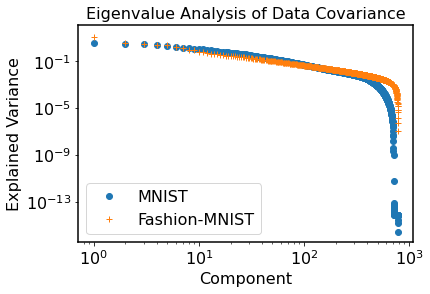

In [9]:
# plot pca components:
plt.figure(figsize=(12,4))
plt.suptitle('explained variance ratio')
plt.subplot(1,2,1)
plt.semilogx(mnist_pcas[-1].explained_variance_ratio_,marker='o',ls='', label='mnist')
plt.plot(fmnist_pcas[-1].explained_variance_ratio_,marker='+',ls='',label='fmnist')
plt.legend()
plt.close()
plt.figure(figsize=(6,4))
plt.title('Eigenvalue Analysis of Data Covariance')
plt.loglog(mnist_pcas[-1].explained_variance_,marker='o',ls='', label='MNIST')
plt.plot(fmnist_pcas[-1].explained_variance_,marker='+',ls='',label='Fashion-MNIST')
plt.ylabel('Explained Variance')
plt.xlabel('Component')
plt.legend(fontsize=16)
try:
  plt.savefig('../plots/eigenvalueAnalysis.png',bbox_inches='tight')
except:
  pass
plt.show()

In [10]:
from pca_classifier import estimate_covariance as cov_est

OOD in data space

In [11]:
covs  = {}
means = {}
for dataset in ['mnist','fmnist']:
    covs[dataset] = cov_est.CovarianceEstimator(mode='ML')
    covs[dataset].fit(masked_datasets_train[dataset],dataset)
    covs[dataset].decompose()

In [12]:
from pca_classifier.classify import get_covariance, get_data_space_log_prob

Use average of unexplained variances as noise estimate

In [ ]:
logprobs={}
for dataset in ['mnist','fmnist']:
    logprobs[dataset]={}
    for n_comp in [8,-1]:
        if n_comp==-1:
            n_comp=len(masked_datasets_test[dataset][0,:])
        N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
        Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp)
        logprobs[dataset][str(n_comp)] = get_data_space_log_prob(masked_datasets_test[dataset],logdetC,Cinv,covs[dataset].mean)

In [ ]:
logprobs_ood={}
for dataset in ['mnist','fmnist']:
    logprobs_ood[dataset]={}
    for n_comp in [8,-1]:
        if n_comp==-1:
            n_comp=len(masked_ood_datasets[dataset][0,:])
        N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
        Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp)
        logprobs_ood[dataset][str(n_comp)] = get_data_space_log_prob(masked_ood_datasets[dataset],logdetC,Cinv,covs[dataset].mean)

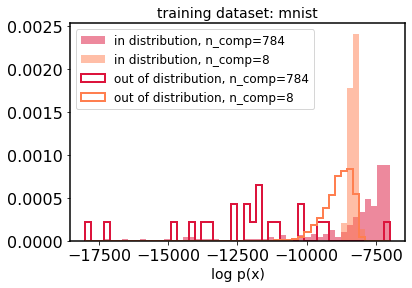

In [ ]:
colors = ['crimson','coral','navy','forestgreen']
for dataset in ['mnist']:
    plt.title('training dataset: %s'%dataset, fontsize=14)
    ii=0
    for n_comp in [-1,8]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-18000,-7000),alpha=0.5)
        ii+=1
    ii=0
    for n_comp in [-1,8]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-18000,-7000),lw=2)
        ii+=1
plt.legend()
plt.xlabel('log p(x)',fontsize=14)
plt.show()

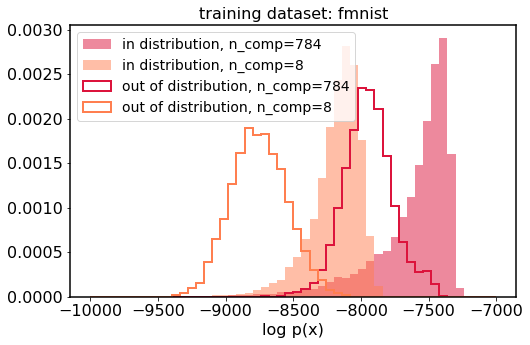

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,len(n_components)))
plt.figure(figsize=(8,5))
for dataset in ['fmnist']:
    plt.title('training dataset: %s'%dataset, fontsize=16)
    ii=0
    for n_comp in [-1,8]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-10000,-7000),alpha=0.5)
        ii+=1
    ii=0
    for n_comp in [-1,8]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-10000,-7000),lw=2)
        ii+=1
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('log p(x)',fontsize=16)
plt.savefig('../plots/ood_with_pca.png',bbox_inches='tight')
plt.show()

OOD in compressed space

In [83]:
def get_comp_log_prob(d,cov,n_comp):
    s = cov.compress(d,n_comp)
    S = cov.vars[:n_comp]
    S_inv = 1./S
    logdetS = np.sum(np.log(S))
    result = -0.5*(np.einsum('ij,j,ij->i',s,S_inv,s,optimize=True)+n_comp*np.log(2*np.pi)+logdetS)

    return result

In [98]:
logprobs={}
for dataset in ['mnist','fmnist']:
    logprobs[dataset]={}
    for n_comp in n_components:
        if n_comp==-1:
            n_comp=len(masked_datasets_test[dataset][0,:])
        logprobs[dataset][str(n_comp)] = get_comp_log_prob(masked_datasets_test[dataset],covs[dataset],n_comp)

In [99]:
logprobs_ood={}
for dataset in ['mnist','fmnist']:
    logprobs_ood[dataset]={}
    for n_comp in n_components:
        if n_comp==-1:
              n_comp=len(masked_ood_datasets[dataset][0,:])
        logprobs_ood[dataset][str(n_comp)] = get_comp_log_prob(masked_ood_datasets[dataset],covs[dataset],n_comp)

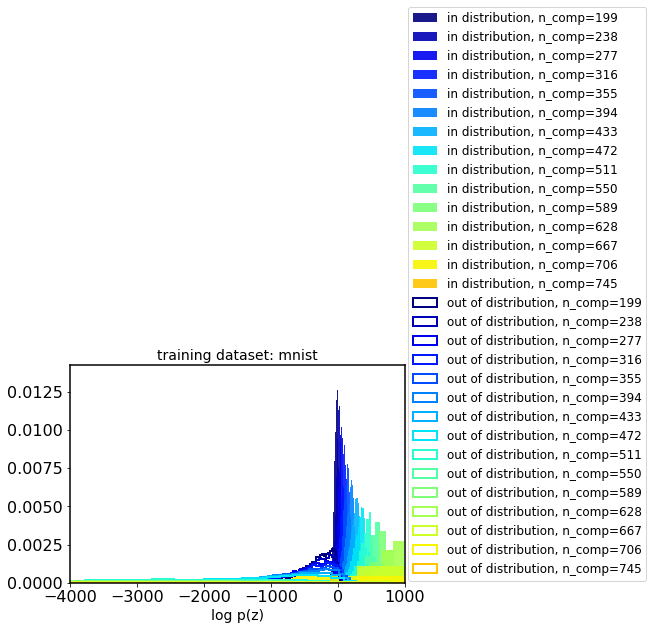

In [86]:
colors = plt.cm.jet(np.linspace(0,1,len(n_components)))
for dataset in ['mnist']:
    plt.title('training dataset: %s'%dataset, fontsize=14)
    ii=0
    for n_comp in n_components[5:-1]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii],alpha=0.9)
        ii+=1
    ii=0
    for n_comp in n_components[5:-1]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii],lw=2)
        ii+=1
plt.xlim(-4000,1000)
plt.legend(loc=(1.01,0.01))
plt.xlabel('log p(z)',fontsize=14)
plt.show()

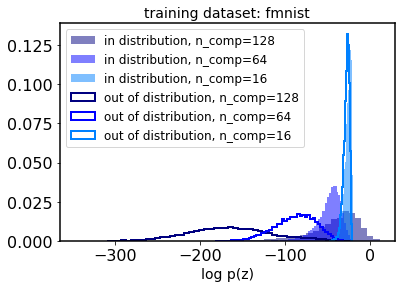

In [27]:
colors = plt.cm.jet(np.linspace(0,1,len(n_components)))
for dataset in ['fmnist']:
    plt.title('training dataset: %s'%dataset, fontsize=14)
    ii=0
    for n_comp in [128,64,16]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii],alpha=0.5)
        ii+=1
    ii=0
    for n_comp in [128,64,16]:
        if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
        _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii],lw=2)
        ii+=1
plt.legend()
plt.xlabel('log p(z)',fontsize=14)
plt.show()

In [100]:
AUROC = {}
AUROC['fmnist']=[]
for dataset in ['fmnist']:
    ii=0
    for n_comp in n_components:
      if n_comp==-1:
            n_comp=masked_ood_datasets[dataset].shape[-1]
      objs_          = np.sort(logprobs[dataset][str(n_comp)])
      objs_ood_      = np.sort(logprobs_ood[dataset][str(n_comp)])
      false_pos      = []
      true_pos       = []
      for ii in range(10000):
          val = objs_[ii]
          true_pos.append(len(np.where(objs_>=val)[0])/len(objs_))
          false_pos.append(len(np.where(objs_ood_>=val)[0])/len(objs_))
      false_pos = np.asarray(false_pos,dtype=np.float64)
      AUROC['fmnist']+=[1-np.sum(false_pos)*1./np.float(len(objs_))]
      print('n_comp:', n_comp, ' AUROC:',np.round(AUROC['fmnist'][-1],3))

n_comp: 4  AUROC: 0.167
n_comp: 8  AUROC: 0.213
n_comp: 16  AUROC: 0.641
n_comp: 32  AUROC: 0.782
n_comp: 43  AUROC: 0.854
n_comp: 82  AUROC: 0.958
n_comp: 121  AUROC: 0.977
n_comp: 160  AUROC: 0.98
n_comp: 199  AUROC: 0.98
n_comp: 238  AUROC: 0.978
n_comp: 277  AUROC: 0.976
n_comp: 316  AUROC: 0.971
n_comp: 355  AUROC: 0.966
n_comp: 394  AUROC: 0.96
n_comp: 433  AUROC: 0.953
n_comp: 472  AUROC: 0.945
n_comp: 511  AUROC: 0.937
n_comp: 550  AUROC: 0.929
n_comp: 589  AUROC: 0.919
n_comp: 628  AUROC: 0.909
n_comp: 667  AUROC: 0.897
n_comp: 706  AUROC: 0.882
n_comp: 745  AUROC: 0.864
n_comp: 784  AUROC: 0.854


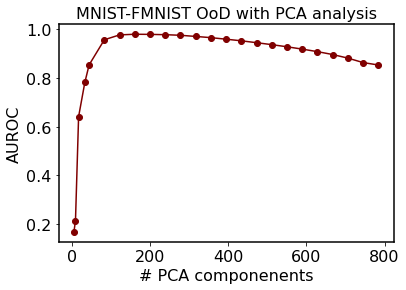

In [103]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('MNIST-FMNIST OoD with PCA analysis')
ax.plot(n_components,AUROC['fmnist'], ls='-', marker='o', color='maroon')

# ax.set_xticklabels(n_components)
# ax.set_xticks(n_components)
ax.set_ylabel('AUROC')
ax.set_xlabel('# PCA componenents')
plt.show()